In [27]:
import numpy as np
import pandas as pd
import datetime
from datetime import date, datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings

# import workalendar
# from workalendar.america import Brazil

warnings.filterwarnings('ignore')
np.random.seed(4590)

skf= KFold(n_splits=5, shuffle=True, random_state=4590)

# by feature select 
# FILTER_FEATURE = ['new_hist_month_diff_min_-_hist_month_diff_min', 'new_hist_merchant_category_id_mean_mean_add_hist_merchant_category_id_mean_mean', 'new_hist_month_lag_mean_mean_add_hist_month_lag_mean_mean', 'hist_year_nunique', 'new_hist_month_diff_max_/_hist_month_diff_max', 'new_hist_merchant_id_mean_mean_add_hist_merchant_id_mean_mean', 'new_hist_month_diff_min_/_hist_month_diff_min', 'new_hist_year_mean_mean_add_hist_year_mean_mean', 'new_hist_dayofweek_mean_mean_/_hist_dayofweek_mean_mean', 'new_hist_weekofyear_mean_mean_add_hist_weekofyear_mean_mean', 'new_hist_dayofweek_nunique_/_hist_dayofweek_nunique', 'new_hist_month_diff_max', 'new_hist_year_mean_mean_/_hist_year_mean_mean', 'new_hist_merchant_category_id_mean_mean_/_hist_merchant_category_id_mean_mean', 'new_hist_merchant_id_mean_mean_/_hist_merchant_id_mean_mean', 'new_hist_year_nunique_/_hist_year_nunique', 'new_hist_month_diff_min', 'new_hist_merchant_category_id_mean_mean', 'hist_month_diff_mean_hist_month_diff_min_ctr', 'new_hist_year_nunique_-_hist_year_nunique', 'dayofweek', 'new_hist_month_mean_mean_/_hist_month_mean_mean', 'new_hist_month_diff_var', 'new_hist_installments_min_-_hist_installments_min', 'new_hist_subsector_id_mean_mean', 'new_hist_dayofweek_nunique', 'new_hist_weekend_mean', 'new_hist_category_2_mean_mean_/_hist_category_2_mean_mean', 'new_hist_merchant_category_id_nunique_-_hist_merchant_category_id_nunique', 'new_hist_month_diff_mean_add_hist_month_diff_mean', 'new_hist_authorized_flag_mean', 'new_hist_merchant_category_id_mean_mean_-_hist_merchant_category_id_mean_mean', 'new_hist_year_mean_mean_-_hist_year_mean_mean', 'new_hist_category_2_mean_mean', 'new_hist_card_id_mean_mean_add_hist_card_id_mean_mean', 'new_hist_month_diff_max_-_hist_month_diff_max', 'new_hist_weekend_sum']

In [4]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv',parse_dates=['purchase_date'])
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv',parse_dates=['purchase_date'])

In [5]:
max_date=df_new_merchant_trans['purchase_date'].max()

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)
gc.collect()

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


7

In [8]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790


In [9]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [10]:

for df in [df_hist_trans,df_new_merchant_trans]:
#     df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['day'] = df['purchase_date'].dt.day
    
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['month_diff'] = ((max_date - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
#     df['authorized_flag_purchase_amount'] = df.apply(lambda x: x['purchase_amount'] \
#                             if x['authorized_flag']>0 else 0 ,axis=1)
    
#     df['unauthorized_flag_purchase_amount'] = df.apply(lambda x: x['purchase_amount'] \
#                             if x['authorized_flag']<1 else 0 ,axis=1)
    
    
    
    
    
                                                                           

In [11]:
# df_hist_trans.groupby('card_id')['month'].unique()

In [12]:
def  get_agg_fea(count_df,prefix):
    aggs = {}
    for col in ['month','day','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum','max','min','mean','var']
    aggs['installments'] = ['sum','max','min','mean','var']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var']
    # aggs['month_diff'] = ['mean']
    aggs['month_diff'] = ['max','min','mean','var']
    aggs['authorized_flag'] = ['sum', 'mean']
    aggs['weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']

    for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id',\
                'category_1','category_2','category_3','month_lag','card_id']:
        count_df[col+'_mean'] = count_df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']   

    new_columns = get_new_columns(prefix,aggs)
    count_df_gp = count_df.groupby('card_id').agg(aggs)
    count_df_gp.columns = new_columns
    count_df_gp.reset_index(drop=False,inplace=True)
    count_df_gp['%s_purchase_date_diff'%prefix] = (count_df_gp['%s_purchase_date_max'%prefix] - count_df_gp['%s_purchase_date_min'%prefix]).dt.days
    count_df_gp['%s_purchase_date_average'%prefix] = count_df_gp['%s_purchase_date_diff'%prefix]/count_df_gp['%s_card_id_size'%prefix]
    count_df_gp['%s_purchase_date_uptonow'%prefix] = (max_date - count_df_gp['%s_purchase_date_max'%prefix]).dt.days
    count_df_gp['%s_purchase_date_uptomin'%prefix] = (max_date - count_df_gp['%s_purchase_date_min'%prefix]).dt.days
    
    return count_df_gp



hist_count_df=get_agg_fea(df_hist_trans,'hist')
df_train = df_train.merge(hist_count_df,on='card_id',how='left')
df_test = df_test.merge(hist_count_df,on='card_id',how='left')
del hist_count_df
gc.collect()
new_count_df = get_agg_fea(df_new_merchant_trans,'new_hist')
df_train = df_train.merge(new_count_df,on='card_id',how='left')
df_test = df_test.merge(new_count_df,on='card_id',how='left')
del new_count_df
gc.collect()

150

In [13]:
for df in [df_train,df_test]:
    
    
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['first_active_monthtonoew'] = ( max_date-pd.to_datetime(df['first_active_month'])).dt.days

    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (max_date- df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_sleep_day'] = df['first_active_monthtonoew'] - df['hist_day_nunique']
    df['new_sleep_day'] = df['first_active_monthtonoew'] - df['new_hist_day_nunique']
    df['total_sleep_day'] = df['hist_sleep_day'] + df['new_sleep_day'] 
    df['diff_sleep_day'] = df['hist_sleep_day'] - df['new_sleep_day']
   
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

    
    df['purchase_amount_diff'] = df['new_hist_purchase_amount_sum']-df['hist_purchase_amount_sum']
    df['purchase_amount_rate'] = df['purchase_amount_diff']/df['hist_purchase_amount_sum']

  

In [14]:
new_hist_feature=[ i for i in df_train  if 'new_hist' in i]

for fea in new_hist_feature:
    if fea in ['new_hist_purchase_date_max','new_hist_purchase_date_min']:
        continue
    print(fea)
    new_fea=fea
    hist_fea=fea.replace("new_hist",'hist')
    df_train[new_fea+"_add_"+hist_fea]=df_train.apply(lambda x: x[new_fea]+x[hist_fea],axis=1)
    df_test[new_fea+"_add_"+hist_fea]=df_test.apply(lambda x: x[new_fea]+x[hist_fea],axis=1)
    df_train[new_fea+"_-_"+hist_fea]=df_train.apply(lambda x: x[new_fea]-x[hist_fea],axis=1)
    df_test[new_fea+"_-_"+hist_fea]=df_test.apply(lambda x: x[new_fea]-x[hist_fea],axis=1)
    df_train[new_fea+"_/_"+hist_fea]=df_train.apply(lambda x: x[new_fea]/(abs(x[hist_fea])+0.01),axis=1)
    df_test[new_fea+"_/_"+hist_fea]=df_test.apply(lambda x: x[new_fea]/(abs(x[hist_fea])+0.01),axis=1)

new_hist_month_nunique
new_hist_day_nunique
new_hist_hour_nunique
new_hist_weekofyear_nunique
new_hist_dayofweek_nunique
new_hist_year_nunique
new_hist_subsector_id_nunique
new_hist_merchant_id_nunique
new_hist_merchant_category_id_nunique
new_hist_purchase_amount_sum
new_hist_purchase_amount_max
new_hist_purchase_amount_min
new_hist_purchase_amount_mean
new_hist_purchase_amount_var
new_hist_installments_sum
new_hist_installments_max
new_hist_installments_min
new_hist_installments_mean
new_hist_installments_var
new_hist_month_lag_max
new_hist_month_lag_min
new_hist_month_lag_mean
new_hist_month_lag_var
new_hist_month_diff_max
new_hist_month_diff_min
new_hist_month_diff_mean
new_hist_month_diff_var
new_hist_authorized_flag_sum
new_hist_authorized_flag_mean
new_hist_weekend_sum
new_hist_weekend_mean
new_hist_category_1_sum
new_hist_category_1_mean
new_hist_card_id_size
new_hist_month_mean_mean
new_hist_hour_mean_mean
new_hist_weekofyear_mean_mean
new_hist_dayofweek_mean_mean
new_hist_yea

In [15]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [16]:
df_train = df_train[df_train.outliers == 0 ]

In [17]:
def get_data_ctr_fea(tj_data,self_data,items=['feature_1','feature_2','feature_3','new_hist_month_diff_mean',
                                          'hist_month_diff_mean', 'hist_month_diff_max','hist_month_diff_min' ]):

    items = items
    
    tj_drop_columns=[i for i in  tj_data.columns  if "_ctr" in i]
    if len(tj_drop_columns)>0:
        tj_data=tj_data.drop(columns=tj_drop_columns)
    
    self_drop_columns=[i for i in  self_data  if "_ctr" in i]
    if len(self_drop_columns)>0:
        print(self_drop_columns)
        self_data.drop(columns=self_drop_columns,inplace=True)
        
    
    for item in items:
        if type(item)==list:
            pr_name="_".join(item)
            merge_columns=item+[pr_name+'_ctr']
        else:
            pr_name=item
            merge_columns=[item,pr_name+'_ctr']
        temp = tj_data.groupby(item, as_index = False)['outliers'].agg({pr_name+'_click':'sum',pr_name+'_count':'count'})
        temp[pr_name+'_ctr'] =1000* (temp[pr_name+'_click']+0.01)/(temp[pr_name+'_count']+0.01)
        
        self_data = pd.merge(self_data, temp[merge_columns], on=item, how='left')
        
    for i in range(len(items)):
        for j in range(i+1, len(items)):
            item_g = [items[i], items[j]]
            merge_columns=item_g+['_'.join(item_g)+'_ctr']
            temp = tj_data.groupby(item_g, as_index=False)['outliers'].agg({'_'.join(item_g)+'_click': 'sum','_'.join(item_g)+'count':'count'})
            temp['_'.join(item_g)+'_ctr'] =1000* (temp['_'.join(item_g)+'_click']+0.01)/(temp['_'.join(item_g)+'count']+0.01)
            self_data = pd.merge(self_data, temp[merge_columns], on=item_g, how='left')
            
    return self_data
            
df_test=get_data_ctr_fea(df_train,df_test)  
print("df_test ctr caluate finished")

from sklearn.model_selection import  StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=4590, shuffle=True)

df_train['index'] = [i for i in range(len(df_train))]

for k, (df_train_in, df_test_in) in enumerate(skf.split(df_train, df_train.outliers.values)):
    df_train_df=df_train.iloc[df_train_in]
    val_df=df_train.iloc[df_test_in]
    val_df=get_data_ctr_fea(df_train_df,val_df)
    if k==0:
        new_df_train_df=val_df
    else:
        new_df_train_df=pd.concat([new_df_train_df,val_df])

df_train=new_df_train_df
df_train.sort_values(by='index',inplace=True)
df_train.drop(columns = ['index'],inplace=True)

print("df_train ctr caluate finished")


df_test ctr caluate finished
df_train ctr caluate finished


In [18]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_day_nunique,hist_hour_nunique,hist_weekofyear_nunique,...,feature_3_new_hist_month_diff_mean_ctr,feature_3_hist_month_diff_mean_ctr,feature_3_hist_month_diff_max_ctr,feature_3_hist_month_diff_min_ctr,new_hist_month_diff_mean_hist_month_diff_mean_ctr,new_hist_month_diff_mean_hist_month_diff_max_ctr,new_hist_month_diff_mean_hist_month_diff_min_ctr,hist_month_diff_mean_hist_month_diff_max_ctr,hist_month_diff_mean_hist_month_diff_min_ctr,hist_month_diff_max_hist_month_diff_min_ctr
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,9,31,23,35,...,0.000195,9.900990,0.000214,0.000197,9.900990,0.000156,0.000139,3.322259,9.900990,0.000166
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,12,31,24,50,...,0.002005,NaN,0.001951,0.000253,NaN,0.001271,0.004454,NaN,NaN,0.005402
0,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,10,19,14,22,...,0.000246,0.185151,0.000283,0.000254,0.086949,0.000156,0.000139,0.072987,0.083326,0.000166
2,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,6,25,16,20,...,0.000246,0.357015,0.000281,0.000868,0.163908,0.000156,0.000500,0.140825,0.666223,0.000532
1,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159790,4,30,22,17,...,0.000246,0.999001,0.000283,0.000872,0.768640,0.000156,0.000500,0.624610,1.426534,0.000534


In [19]:
# Dealing with the one nan in df_test.first_active_month a bit arbitrarily for now
df_test.loc[df_test['first_active_month'].isna(),'first_active_month'] = df_test.iloc[11577]['first_active_month']

In [20]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 128.75 Mb (69.9% reduction)
Mem. usage decreased to 78.05 Mb (70.4% reduction)


In [21]:
bed_fea = ['new_hist_month_diff_min_-_hist_month_diff_min', 'new_hist_year_mean_mean_/_hist_year_mean_mean', 'new_hist_year_nunique_/_hist_year_nunique', 'new_hist_year_mean_mean_add_hist_year_mean_mean', 'new_hist_merchant_category_id_mean_mean_-_hist_merchant_category_id_mean_mean', 'new_hist_month_lag_mean_mean_-_hist_month_lag_mean_mean', 'new_hist_month_diff_max_add_hist_month_diff_max', 'new_hist_month_diff_min', 'new_hist_weekend_sum_/_hist_weekend_sum', 'new_hist_year_mean_mean', 'new_hist_merchant_id_mean_mean_add_hist_merchant_id_mean_mean', 'new_hist_purchase_amount_sum_-_hist_purchase_amount_sum', 'new_hist_month_diff_var', 'new_hist_month_diff_max_/_hist_month_diff_max', 'new_hist_weekofyear_nunique', 'new_hist_month_diff_max_-_hist_month_diff_max', 'new_hist_weekend_mean_add_hist_weekend_mean', 'new_hist_month_mean_mean_-_hist_month_mean_mean', 'new_hist_month_diff_mean', 'hist_year_nunique', 'new_hist_weekend_mean', 'new_hist_year_mean_mean_-_hist_year_mean_mean', 'hist_month_diff_mean_hist_month_diff_min_ctr', 'hist_dayofweek_nunique', 'new_hist_merchant_category_id_mean_mean', 'new_hist_weekend_sum', 'new_hist_installments_min_-_hist_installments_min', 'new_hist_authorized_flag_mean', 'new_hist_weekend_mean_/_hist_weekend_mean', 'hist_month_diff_min', 'new_hist_card_id_mean_mean_add_hist_card_id_mean_mean', 'new_hist_month_mean_mean_/_hist_month_mean_mean', 'new_hist_category_2_mean_mean', 'new_hist_month_diff_min_/_hist_month_diff_min', 'new_hist_merchant_category_id_mean_mean_add_hist_merchant_category_id_mean_mean', 'new_hist_dayofweek_nunique_/_hist_dayofweek_nunique', 'new_hist_month_mean_mean', 'new_hist_day_nunique_add_hist_day_nunique', 'new_hist_subsector_id_nunique_-_hist_subsector_id_nunique', 'new_hist_purchase_amount_max_add_hist_purchase_amount_max', 'new_hist_month_diff_mean_add_hist_month_diff_mean', 'new_hist_subsector_id_mean_mean', 'new_hist_year_nunique_-_hist_year_nunique', 'new_hist_dayofweek_nunique_-_hist_dayofweek_nunique', 'new_hist_merchant_id_mean_mean_/_hist_merchant_id_mean_mean']

In [22]:
# bed_fea =['new_hist_month_diff_min', 'new_hist_authorized_flag_mean', 'new_hist_year_mean_mean', 'new_hist_year_nunique_/_hist_year_nunique', 'new_hist_year_nunique_-_hist_year_nunique']
del_col =  ['card_id', 'first_active_month','target','outliers']+bed_fea

features = [c for c in df_train.columns if c not in del_col ]

target = df_train['target']

train_y = target 
# df_train.drop(columns  = ["card_id","target"],inplace=True)
# df_test.drop(columns = ["card_id"],inplace=True)

In [23]:
print(len(features))

262


In [24]:
features

['feature_1',
 'feature_2',
 'feature_3',
 'hist_month_nunique',
 'hist_day_nunique',
 'hist_hour_nunique',
 'hist_weekofyear_nunique',
 'hist_subsector_id_nunique',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_var',
 'hist_installments_sum',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_mean',
 'hist_installments_var',
 'hist_purchase_date_max',
 'hist_purchase_date_min',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_lag_mean',
 'hist_month_lag_var',
 'hist_month_diff_max',
 'hist_month_diff_mean',
 'hist_month_diff_var',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_weekend_sum',
 'hist_weekend_mean',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_card_id_size',
 'hist_month_mean_mean',
 'hist_hour_mean_mean',
 'hist_weekofyear_mean_mean',
 'hist_dayofweek_m

In [28]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         'lambda_l2':0.1,
         "verbosity": -1,
         "n_jobs":10,
         "random_state": 4590}
NFOLD = 5
oof_train = np.zeros((len(df_train),1))
oof_test = np.zeros((len(df_test),1))
oof_test_skf = np.zeros((NFOLD,len(df_test),))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(df_train,target)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features],target.iloc[trn_idx])#ategorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][features],target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration).reshape(-1,1)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    oof_test_skf[fold_,:]= clf.predict(df_test[features], num_iteration=clf.best_iteration)    
oof_test = oof_test_skf.mean(axis=0)
mean_loss=np.sqrt(mean_squared_error(oof_train.reshape(-1), target))


fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 1.56603	valid_1's rmse: 1.602
[400]	training's rmse: 1.54172	valid_1's rmse: 1.58751
[600]	training's rmse: 1.52795	valid_1's rmse: 1.58272
[800]	training's rmse: 1.51732	valid_1's rmse: 1.58082
[1000]	training's rmse: 1.50814	valid_1's rmse: 1.57972
[1200]	training's rmse: 1.49987	valid_1's rmse: 1.5791
[1400]	training's rmse: 1.49208	valid_1's rmse: 1.57851
[1600]	training's rmse: 1.48442	valid_1's rmse: 1.57825
[1800]	training's rmse: 1.47716	valid_1's rmse: 1.57806
[2000]	training's rmse: 1.47016	valid_1's rmse: 1.57779
[2200]	training's rmse: 1.46316	valid_1's rmse: 1.5776
[2400]	training's rmse: 1.4563	valid_1's rmse: 1.57726
[2600]	training's rmse: 1.44961	valid_1's rmse: 1.57709
[2800]	training's rmse: 1.44308	valid_1's rmse: 1.57704
[3000]	training's rmse: 1.4367	valid_1's rmse: 1.577
[3200]	training's rmse: 1.43048	valid_1's rmse: 1.57688
[3400]	training's rmse: 1.42433	valid_1's rmse

In [29]:
mean_loss=np.sqrt(mean_squared_error(oof_train.reshape(-1), target))
print(mean_loss)
train_prob=pd.DataFrame(oof_train)
train_prob.columns=['class1']
train_prob.to_csv("去除异常值_oof/train_prob_%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test)
test_prob.columns=['class1']
test_prob.to_csv("去除异常值_oof/test_prob_%s.csv"%mean_loss,index=False)

np.save("train_y",target)

1.5554992736296018


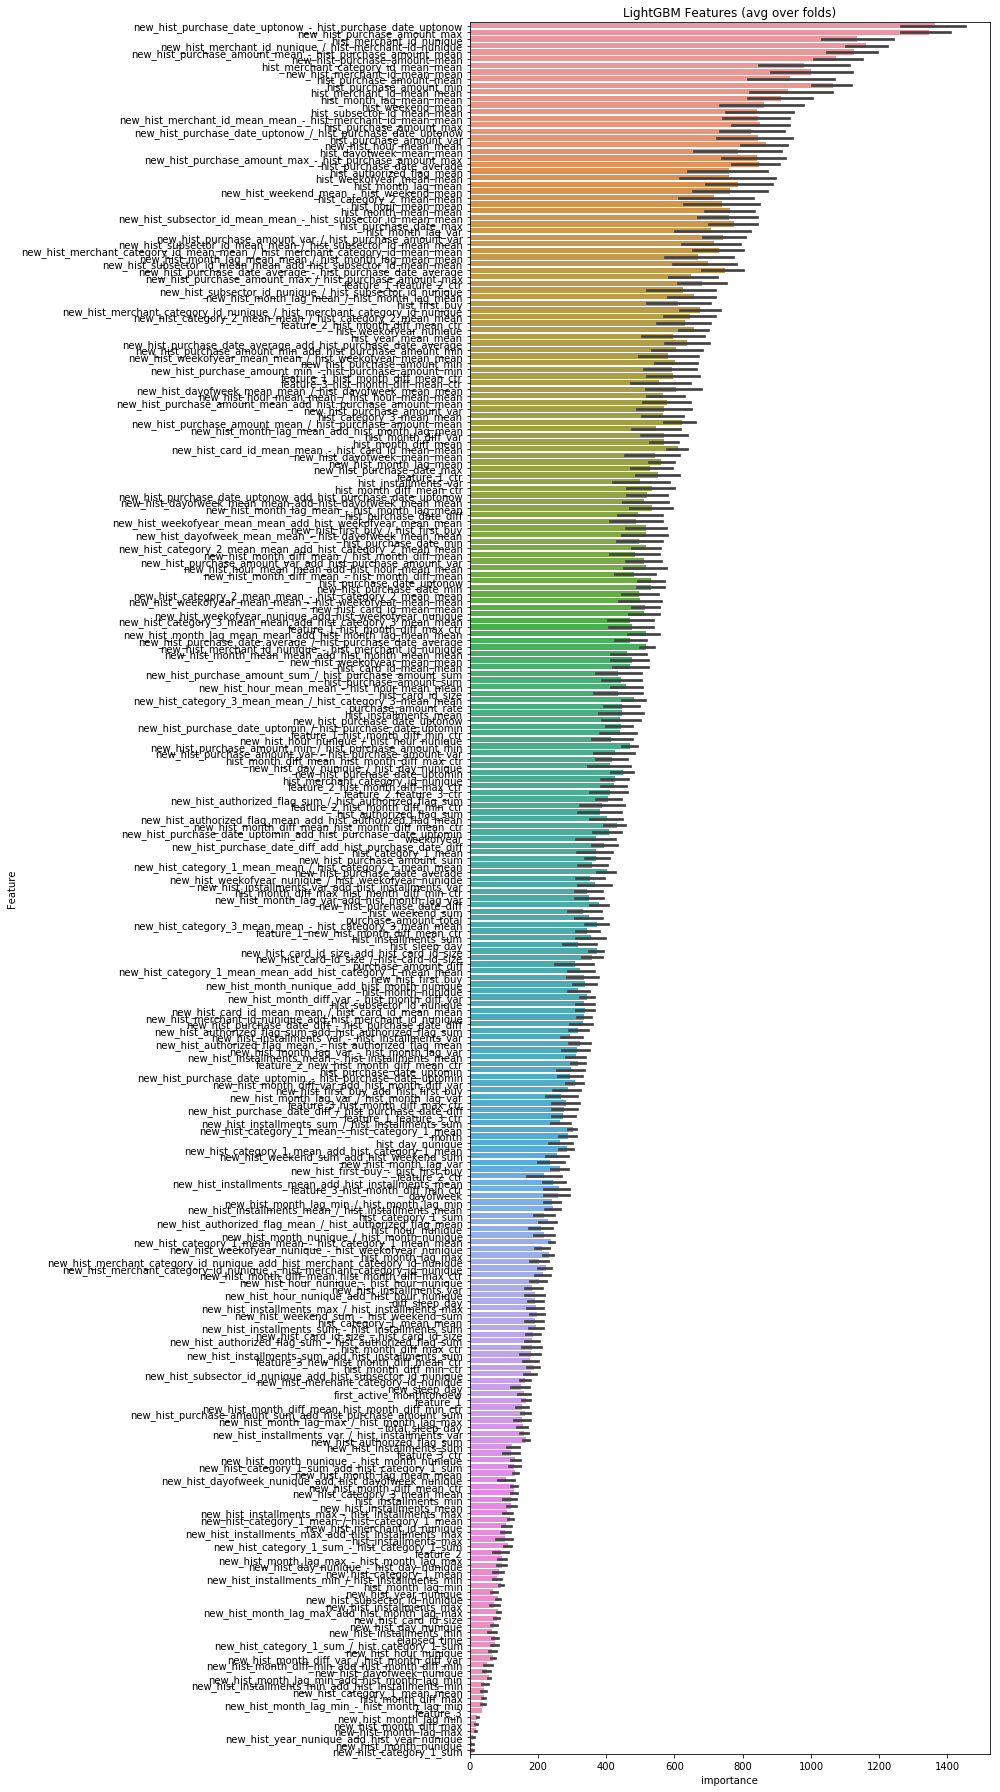

In [30]:
#cv: 3.6497796168629439  lb:3.693
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:500].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [31]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test
sub_df.to_csv("去除异常值_sub/submission_%s.csv"%mean_loss, index=False)

In [32]:
feature_importance_df.sort_values(by='importance',inplace=True)
feature_importance_df

,Feature,importance,fold
53,new_hist_month_nunique,4,4
53,new_hist_month_nunique,5,1
79,new_hist_category_1_sum,5,2
79,new_hist_category_1_sum,5,4
120,new_hist_year_nunique_add_hist_year_nunique,6,1
53,new_hist_month_nunique,6,2
53,new_hist_month_nunique,8,5
120,new_hist_year_nunique_add_hist_year_nunique,10,4
120,new_hist_year_nunique_add_hist_year_nunique,11,5
79,new_hist_category_1_sum,11,1


In [33]:
# #feature select

# def get_feature_importances(data, shuffle, seed=None):
#     # Gather real features
#     train_features = [f for f in data if f not in ['card_id', 'first_active_month','target','outliers']]
#     # Go over fold and keep track of CV score (train and valid) and feature importances
    
#     # Shuffle target if required
#     y = data['target'].copy()
#     if shuffle:
#         # Here you could as well use a binomial distribution
#         y = data['target'].copy().sample(frac=1.0)
    
#     # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
#     dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
#     lgb_params = {
#         'objective': 'regression',
#         'boosting_type': 'rf',
#         'subsample': 0.623,
#         'colsample_bytree': 0.7,
#         'num_leaves': 127,
#         'max_depth': 8,
#         'seed': 4590,
#         'bagging_freq': 1,
#         'n_jobs': 4
#     }
    
#     # Fit the model
#     clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

#     # Get feature importances
#     imp_df = pd.DataFrame()
#     imp_df["feature"] = list(train_features)
#     imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
#     imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    
#     return imp_df


# # Seed the unexpected randomness of this world
# np.random.seed(123)
# # Get the actual importance, i.e. without shuffling
# actual_imp_df = get_feature_importances(data=df_train, shuffle=False)


# null_imp_df = pd.DataFrame()
# nb_runs = 80
# import time
# start = time.time()
# dsp = ''
# for i in range(nb_runs):
#     # Get current run importances
#     imp_df = get_feature_importances(data=df_train, shuffle=True)
#     imp_df['run'] = i + 1 
#     # Concat the latest importances with the old ones
#     null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
#     # Erase previous message
#     for l in range(len(dsp)):
#         print('\b', end='', flush=True)
#     # Display current run and time used
#     spent = (time.time() - start) / 60
#     dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
#     print(dsp, end='', flush=True)

# """
# Score features
# There are several ways to score features :

# Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
# Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
# In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

# """
    
# feature_scores = []
# for _f in actual_imp_df['feature'].unique():
#     f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
#     f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
#     gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
#     f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
#     f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
#     split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
#     feature_scores.append((_f, split_score, gain_score))

# scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

# thr_list=scores_df['gain_score'].tolist()
# thr_list=[ i for i in set(thr_list)]
# thr_list=sorted(thr_list)



In [34]:

# def test_feature(test_fea):
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
#     train_x = df_train[test_fea].values
#     train_y = df_train['target']
#     oof = np.zeros((train_x.shape[0],1))
#     df_train.reset_index(drop=True,inplace=True)
#     for idx,(idx_trn,idx_val) in enumerate(kf.split(train_x,df_train['outliers'].values)):
#         print('第 %d fold'%idx)
#         tr_x,tr_y,val_x,val_y=train_x[idx_trn],train_y[idx_trn],train_x[idx_val],train_y[idx_val]

#         trn_data = lgb.Dataset(tr_x,tr_y)#, categorical_feature=categorical_feats)
#         val_data = lgb.Dataset(val_x,val_y)#, categorical_feature=categorical_feats)

#         clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
#         oof[idx_val] = clf.predict(val_x, num_iteration=clf.best_iteration).reshape(-1,1)

#     loss=np.sqrt(mean_squared_error(oof.reshape(-1), target))
#     print('mean loss %f'%loss)
#     return loss


# test_dict={}
# for idx,i in enumerate(thr_list):
#     if idx>50:
#         break
#     print(i)
#     bed_fea=set(scores_df[scores_df['gain_score']<=i]['feature'].tolist())
#     bed_fea=[i for i in bed_fea]
#     print(bed_fea)
#     del_col =  ['card_id', 'first_active_month','target','outliers']+bed_fea
#     df_test_fea = [c for c in df_train.columns if c not in del_col ]
#     test_dict[''.join(bed_fea)]=test_feature(df_test_fea)

In [35]:
df_merchant = pd.read_csv("../input/merchants.csv")
add_columns =  [i for  i in df_merchant.columns if i not in df_hist_trans.columns]
df_hist_trans = pd.merge(df_hist_trans,df_merchant[['merchant_id']+add_columns],how='left',on=['merchant_id'])
df_new_merchant_trans = pd.merge(df_new_merchant_trans,df_merchant[['merchant_id']+add_columns],how='left',on=['merchant_id'])

In [36]:
df_hist_ca=['authorized_flag','category_1','installments','category_3','merchant_category_id','merchant_id','category_2','state_id',\
          'subsector_id','purchase_amount' ]+add_columns

hist_text_feature={}
gp=df_hist_trans.groupby('card_id')
for fea  in df_hist_ca:
    hist_text_feature[fea+"_hist_text"]=[]
hist_text_feature['card_id']=[]
for cid,cid_df in  gp:
    hist_text_feature['card_id'].append(cid)
    for  fea in  df_hist_ca:
        if fea=='card_id':
            continue
        hist_text_feature[fea+"_hist_text"].append(" ".join(cid_df[fea].astype(str).tolist()))
df_hist_text=pd.DataFrame(hist_text_feature)


new_mer_text_feature={}
gp=df_new_merchant_trans.groupby('card_id')
for fea  in df_hist_ca:
    new_mer_text_feature[fea+"_new_mer_text"]=[]
new_mer_text_feature['card_id']=[]
for cid,cid_df in  gp:
    new_mer_text_feature['card_id'].append(cid)
    for  fea in  df_hist_ca:
        if fea=='card_id':
            continue
        new_mer_text_feature[fea+"_new_mer_text"].append(" ".join(cid_df[fea].astype(str).tolist()))
        
df_new_mer_text=pd.DataFrame(new_mer_text_feature)

In [37]:
df_train=pd.merge(df_train,df_hist_text,how='left',on='card_id')
df_test=pd.merge(df_test,df_hist_text,how='left',on='card_id')

df_all=pd.concat([df_train,df_test])

text_fea=[i for i in df_all.columns if "text"in i]

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse


cv=CountVectorizer(analyzer='word',token_pattern=u"(?u)\\b\\w+\\b")



for idx,i in enumerate(text_fea):
    cv.fit(df_all[i])
    tr_x=cv.transform(df_train[i])
    te_x=cv.transform(df_test[i])
    
    if idx==0:
        cv_Train_x=tr_x
        cv_Test_x=te_x
    else:
        cv_Train_x=sparse.hstack((cv_Train_x,tr_x))
        cv_Test_x=sparse.hstack((cv_Test_x,te_x))
    
print(cv_Train_x.shape,cv_Test_x.shape)


(199710, 976627) (123623, 976627)


In [38]:
from sklearn.feature_selection  import  SelectKBest
from sklearn.feature_selection  import  chi2

skb = SelectKBest(chi2,500)
skb.fit(cv_Train_x,df_train['outliers'].values)

cv_Train_x_filter = skb.transform(cv_Train_x)
cv_Test_x_filter = skb.transform(cv_Test_x)

print(cv_Train_x_filter.shape,cv_Test_x_filter.shape)


(199710, 500) (123623, 500)


In [39]:

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

train_x=df_train[features].values
test_x=df_test[features].values
train_y=df_train['target'].values

train_x=sparse.hstack((train_x,cv_Train_x_filter),'csr')
test_x=sparse.hstack((test_x,cv_Test_x_filter),'csr')
oof_train2 = np.zeros((train_x.shape[0],1))
oof_test2 = np.zeros((test_x.shape[0],1))
oof_test2_skf = np.zeros((NFOLD,test_x.shape[0],))

print(train_x.shape,test_x.shape)

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x)):
    print("fold {}".format(fold_))
    x_tr,y_tr,x_te,y_te=train_x[trn_idx],train_y[trn_idx],train_x[val_idx],train_y[val_idx]
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train2[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)

    oof_test2_skf[fold_,:]= clf.predict(test_x, num_iteration=clf.best_iteration)    
oof_test2 = oof_test2_skf.mean(axis=0)
mean_loss=np.sqrt(mean_squared_error(oof_train2.reshape(-1), target))
print(mean_loss)

(199710, 762) (123623, 762)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 1.56558	valid_1's rmse: 1.60165
[400]	training's rmse: 1.54098	valid_1's rmse: 1.58688
[600]	training's rmse: 1.52687	valid_1's rmse: 1.58224
[800]	training's rmse: 1.51603	valid_1's rmse: 1.58033
[1000]	training's rmse: 1.50667	valid_1's rmse: 1.57939
[1200]	training's rmse: 1.49818	valid_1's rmse: 1.57885
[1400]	training's rmse: 1.49009	valid_1's rmse: 1.57841
[1600]	training's rmse: 1.48222	valid_1's rmse: 1.5781
[1800]	training's rmse: 1.47475	valid_1's rmse: 1.57789
[2000]	training's rmse: 1.46765	valid_1's rmse: 1.57768
[2200]	training's rmse: 1.46073	valid_1's rmse: 1.57751
[2400]	training's rmse: 1.45386	valid_1's rmse: 1.57742
[2600]	training's rmse: 1.44718	valid_1's rmse: 1.57727
[2800]	training's rmse: 1.44056	valid_1's rmse: 1.57723
[3000]	training's rmse: 1.434	valid_1's rmse: 1.57714
[3200]	training's rmse: 1.42766	valid_1's rmse: 1.57716
[3400]	traini

In [40]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test2
sub_df.to_csv("去除异常值_sub/submission_%s.csv"%mean_loss, index=False)
mean_loss=np.sqrt(mean_squared_error(oof_train2.reshape(-1), target))
print(mean_loss)
train_prob=pd.DataFrame(oof_train2)
train_prob.columns=['class1']
train_prob.to_csv("去除异常值_oof/train_prob_%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test2)
test_prob.columns=['class1']
test_prob.to_csv("去除异常值_oof/test_prob_%s.csv"%mean_loss,index=False)

np.save("train_y",target)

1.5544792177390243


In [41]:
df_train=pd.merge(df_train,df_new_mer_text,how='left',on='card_id')
df_test=pd.merge(df_test,df_new_mer_text,how='left',on='card_id')

df_all=pd.concat([df_train,df_test])

text_fea=[i for i in df_all.columns if "_new_mer_text"in i]

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse


cv=CountVectorizer(analyzer='word',token_pattern=u"(?u)\\b\\w+\\b")



for idx,i in enumerate(text_fea):
    df_all[i].fillna('-1',inplace=True)
    df_train[i].fillna('-1',inplace=True)
    df_test[i].fillna('-1',inplace=True)
    cv.fit(df_all[i])
    tr_x=cv.transform(df_train[i])
    te_x=cv.transform(df_test[i])
    
    if idx==0:
        cv_Train_x_2=tr_x
        cv_Test_x_2=te_x
    else:
        cv_Train_x_2=sparse.hstack((cv_Train_x_2,tr_x))
        cv_Test_x_2=sparse.hstack((cv_Test_x_2,te_x))
    
print(cv_Train_x_2.shape,cv_Test_x_2.shape)



(199710, 676143) (123623, 676143)


In [42]:
from sklearn.feature_selection  import  SelectKBest
from sklearn.feature_selection  import  chi2

skb = SelectKBest(chi2,500)
skb.fit(cv_Train_x_2,df_train['outliers'].values)

cv_Train_x_2_filter = skb.transform(cv_Train_x_2)
cv_Test_x_2_filter = skb.transform(cv_Test_x_2)

print(cv_Train_x_2_filter.shape,cv_Test_x_2_filter.shape)



(199710, 500) (123623, 500)


In [43]:
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

train_x=df_train[features].values
test_x=df_test[features].values
train_y=df_train['target'].values

train_x=sparse.hstack((train_x,cv_Train_x_2_filter),'csr')
test_x=sparse.hstack((test_x,cv_Test_x_2_filter),'csr')
oof_train3 = np.zeros((train_x.shape[0],1))
oof_test3 = np.zeros((test_x.shape[0],1))
oof_test3_skf = np.zeros((NFOLD,test_x.shape[0],))

print(train_x.shape,test_x.shape)

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x)):
    print("fold {}".format(fold_))
    x_tr,y_tr,x_te,y_te=train_x[trn_idx],train_y[trn_idx],train_x[val_idx],train_y[val_idx]
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train3[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)

    oof_test3_skf[fold_,:]= clf.predict(test_x, num_iteration=clf.best_iteration)    
oof_test3 = oof_test3_skf.mean(axis=0)
mean_loss=np.sqrt(mean_squared_error(oof_train3.reshape(-1), target))
print(mean_loss)


sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test3
sub_df.to_csv("去除异常值_sub/submission_%s.csv"%mean_loss, index=False)
mean_loss=np.sqrt(mean_squared_error(oof_train3.reshape(-1), target))
print(mean_loss)
train_prob=pd.DataFrame(oof_train3)
train_prob.columns=['class1']
train_prob.to_csv("去除异常值_oof/train_prob_%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test3)
test_prob.columns=['class1']
test_prob.to_csv("去除异常值_oof/test_prob_%s.csv"%mean_loss,index=False)

np.save("train_y",target)

(199710, 762) (123623, 762)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 1.56602	valid_1's rmse: 1.60209
[400]	training's rmse: 1.54169	valid_1's rmse: 1.58753
[600]	training's rmse: 1.52795	valid_1's rmse: 1.58274
[800]	training's rmse: 1.51724	valid_1's rmse: 1.58087
[1000]	training's rmse: 1.50808	valid_1's rmse: 1.57984
[1200]	training's rmse: 1.49996	valid_1's rmse: 1.5792
[1400]	training's rmse: 1.49209	valid_1's rmse: 1.5787
[1600]	training's rmse: 1.48451	valid_1's rmse: 1.57843
[1800]	training's rmse: 1.47721	valid_1's rmse: 1.57817
[2000]	training's rmse: 1.47007	valid_1's rmse: 1.57799
[2200]	training's rmse: 1.46317	valid_1's rmse: 1.5778
[2400]	training's rmse: 1.45649	valid_1's rmse: 1.57767
[2600]	training's rmse: 1.44985	valid_1's rmse: 1.57758
[2800]	training's rmse: 1.44343	valid_1's rmse: 1.57747
[3000]	training's rmse: 1.43718	valid_1's rmse: 1.5774
[3200]	training's rmse: 1.43099	valid_1's rmse: 1.57739
[3400]	trainin

In [44]:
sp_tr_x  =  sparse.hstack((cv_Train_x,cv_Train_x_2))
sp_te_x  =  sparse.hstack((cv_Test_x,cv_Test_x_2))
print(sp_tr_x.shape,sp_te_x.shape)

skb = SelectKBest(chi2,800)
skb.fit(sp_tr_x,df_train['outliers'].values)

sp_tr_x_filter = skb.transform(sp_tr_x)
sp_te_x_filter = skb.transform(sp_te_x)

print(sp_tr_x_filter.shape,sp_te_x_filter.shape)

(199710, 1652770) (123623, 1652770)
(199710, 800) (123623, 800)


In [45]:


from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse



oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

train_x=df_train[features].values
test_x=df_test[features].values
print(train_x.shape,test_x.shape)
train_y= df_train['target'].values
train_x = sparse.hstack((train_x,sp_tr_x_filter),'csr')
test_x = sparse.hstack((test_x,sp_te_x_filter),'csr')
print(train_x.shape,test_x.shape)




oof_train4 = np.zeros((train_x.shape[0],1))
oof_test4 = np.zeros((test_x.shape[0],1))
oof_test4_skf = np.zeros((NFOLD,test_x.shape[0],))

print(train_x.shape,test_x.shape)

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x)):
    print("fold {}".format(fold_))
    x_tr,y_tr,x_te,y_te=train_x[trn_idx],train_y[trn_idx],train_x[val_idx],train_y[val_idx]
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train4[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)

    oof_test4_skf[fold_,:]= clf.predict(test_x, num_iteration=clf.best_iteration)    
oof_test4 = oof_test4_skf.mean(axis=0)
mean_loss=np.sqrt(mean_squared_error(oof_train4.reshape(-1), target))
print(mean_loss)


sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test4
sub_df.to_csv("去除异常值_sub/submission_%s.csv"%mean_loss, index=False)
mean_loss=np.sqrt(mean_squared_error(oof_train4.reshape(-1), target))
print(mean_loss)
train_prob=pd.DataFrame(oof_train4)
train_prob.columns=['class1']
train_prob.to_csv("去除异常值_oof/train_prob_%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test4)
test_prob.columns=['class1']
test_prob.to_csv("去除异常值_oof/test_prob_%s.csv"%mean_loss,index=False)

np.save("train_y",target)

(199710, 262) (123623, 262)
(199710, 1062) (123623, 1062)
(199710, 1062) (123623, 1062)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 1.56593	valid_1's rmse: 1.60203
[400]	training's rmse: 1.54165	valid_1's rmse: 1.58748
[600]	training's rmse: 1.52796	valid_1's rmse: 1.58271
[800]	training's rmse: 1.51735	valid_1's rmse: 1.58085
[1000]	training's rmse: 1.50827	valid_1's rmse: 1.57979
[1200]	training's rmse: 1.50007	valid_1's rmse: 1.57927
[1400]	training's rmse: 1.49206	valid_1's rmse: 1.57885
[1600]	training's rmse: 1.48449	valid_1's rmse: 1.57847
[1800]	training's rmse: 1.47725	valid_1's rmse: 1.57805
[2000]	training's rmse: 1.47037	valid_1's rmse: 1.57793
[2200]	training's rmse: 1.46347	valid_1's rmse: 1.57761
[2400]	training's rmse: 1.45677	valid_1's rmse: 1.57763
[2600]	training's rmse: 1.45034	valid_1's rmse: 1.57756
[2800]	training's rmse: 1.44381	valid_1's rmse: 1.57742
[3000]	training's rmse: 1.43759	valid_1's rmse: 1.57731
[3200]

In [46]:
from sklearn.linear_model import BayesianRidge

train_stack = np.concatenate([oof_train,oof_train2,oof_train3,oof_train4],axis=1)
test_stack = np.concatenate([oof_test.reshape(-1,1),oof_test2.reshape(-1,1),\
                             oof_test3.reshape(-1,1),oof_test4.reshape(-1,1)],axis=1)
print(train_stack.shape,test_stack.shape)

oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_stack)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
stack_loss=np.sqrt(mean_squared_error(target.values, oof_stack))
print(stack_loss)
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_3
sub_df.to_csv("去除异常值_sub/submission_%s.csv"%stack_loss, index=False)

train_prob=pd.DataFrame(oof_stack)
train_prob.columns=['class1']
train_prob.to_csv("去除异常值_oof/train_prob_%s.csv"%stack_loss,index=False)

test_prob=pd.DataFrame(predictions_3)
test_prob.columns=['class1']
test_prob.to_csv("去除异常值_oof/test_prob_%s.csv"%stack_loss,index=False)

(199710, 4) (123623, 4)
fold 0
fold 1
fold 2
fold 3
fold 4
1.5540623551602637
